In [1]:
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
import functions as f

In [4]:
import soilconctomcnp as sm

In [5]:
mass_functions = pd.read_pickle('data/massfunctions.pkl')

In [6]:
mass_functions

,combo_id,combo,carbon_func,nitrogen_func,carbon_params,nitrogen_params
0,0,const,<function const at 0x76b9ae702830>,<function const at 0x76b9ae702830>,[0.004992609570236395],[0.004992609570236395]
1,1,linear,<function linear at 0x76b9ae7028c0>,<function linear at 0x76b9ae7028c0>,"[0.00019862192575141282, 0.007971863609826437]","[0.00019862192575141282, 0.007971863609826437]"
2,2,plane,<function plane at 0x76b95c6b15a0>,<function plane at 0x76b95c6b15a0>,"[1.5303714398684165e-08, 9.667953700526266e-11...","[1.5303714398684165e-08, 9.667953700526266e-11..."
3,3,quad,<function quad at 0x76b95c6b1630>,<function quad at 0x76b95c6b1630>,"[-4.1382608135894603e-13, 3.689119991081925e-1...","[-4.1382608135894603e-13, 3.689119991081925e-1..."
4,4,quad_plane,<function quad_plane at 0x76b95c6b16c0>,<function quad_plane at 0x76b95c6b16c0>,"[-1.8475158769238626e-13, 3.738134677365824e-1...","[-1.8475158769238626e-13, 3.738134677365824e-1..."


# Deciding Path

In [7]:
# read json file 'data/feild_info.json' and store it in a variable called 'field_info'
import json
with open('data/field_info.json') as f:
    field_info = json.load(f)


In [8]:
fence = np.array(field_info['corners'])

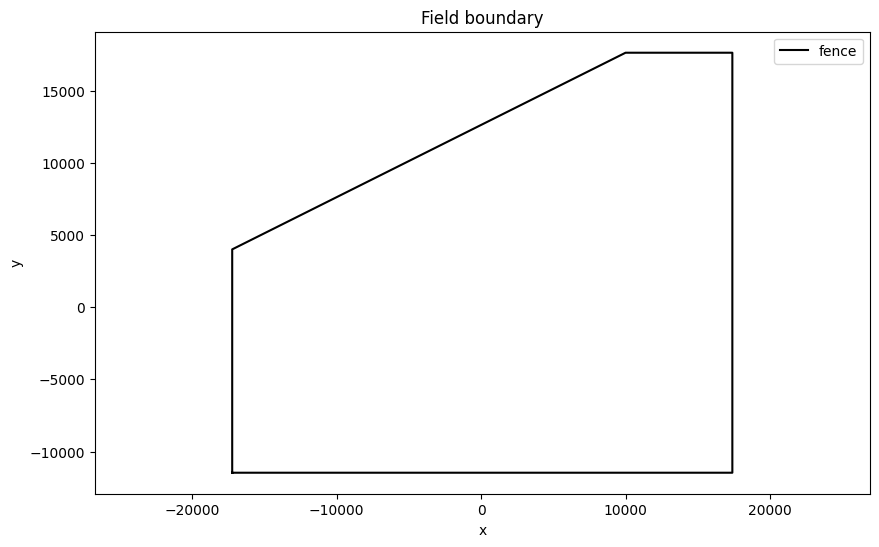

In [9]:

plt.figure(figsize=(10, 6))
plt.plot(fence[:, 0], fence[:, 1], 'k-', label='fence')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Field boundary')
plt.axis('equal')
plt.show()


In [10]:
fence[-2]

array([-17238.30257494,   4000.        ])

dis_between_points: 1097.0904710566724 cm


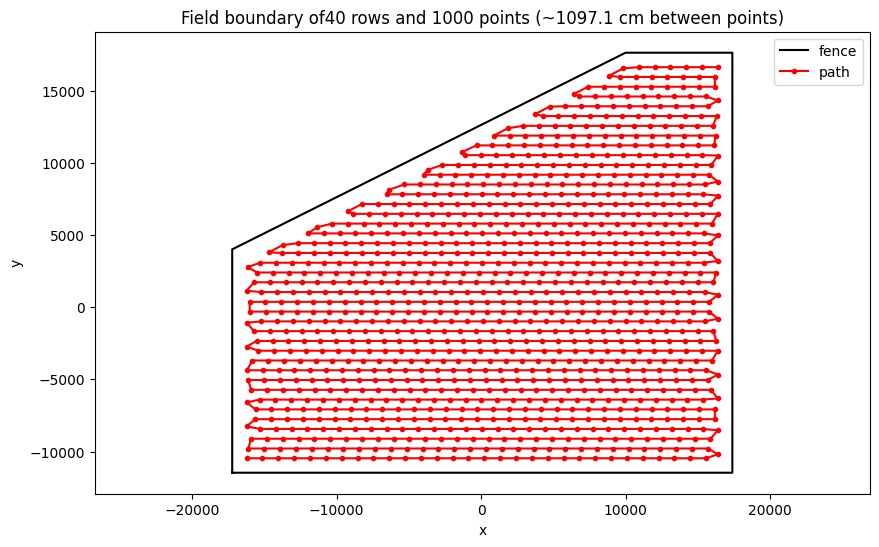

In [11]:
from scipy.interpolate import interp1d

bot_x = fence[0][0]+1000
top_x = fence[1][0]-1000
bot_y = fence[0][1]+1000
top_y = fence[2][1]-1000

a = (fence[-2][0]+1000, fence[-2][1]-1000)
b = (fence[-3][0], fence[-3][1]-1000)

rows = 40

n_points_on_path = 1000

path = [
    (bot_x,bot_y),
    (top_x,bot_y),
]

for i in range(1,rows+1):
    if i%2 == 1:
        path.append((top_x,bot_y+i*(top_y-bot_y)/rows))
        _x = bot_x
        _y = bot_y+i*(top_y-bot_y)/rows
        if _y > a[1]:
            _x = ((b[0]-a[0])/(b[1]-a[1]))*(_y-a[1])+a[0]

        path.append((_x,bot_y+i*(top_y-bot_y)/rows))
    else:
        _x = bot_x
        _y = bot_y+i*(top_y-bot_y)/rows
        if _y > a[1]:
            _x = ((b[0]-a[0])/(b[1]-a[1]))*(_y-a[1])+a[0]
        path.append((_x,bot_y+i*(top_y-bot_y)/rows))
        path.append((top_x,bot_y+i*(top_y-bot_y)/rows))

path = np.array(path)

# linspace on path without functions.py
# Calculate cumulative distance along the path
distances = np.sqrt(np.sum(np.diff(path, axis=0)**2, axis=1))
cumulative_distances = np.insert(np.cumsum(distances), 0, 0)

# Interpolate to get evenly spaced points
interp_func = interp1d(cumulative_distances, path, axis=0, kind='linear')
evenly_spaced_distances = np.linspace(0, cumulative_distances[-1], n_points_on_path)
dis_between_points = np.diff(evenly_spaced_distances)[0]
print('dis_between_points:', dis_between_points, 'cm')
path = interp_func(evenly_spaced_distances)

plt.figure(figsize=(10, 6))
plt.plot(fence[:, 0], fence[:, 1], 'k-', label='fence')
plt.plot(path[:, 0], path[:, 1], 'r-', label='path', marker='.')

plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Field boundary of'+str(rows)+' rows and '+str(n_points_on_path)+' points (~'+str(round(dis_between_points,1))+' cm between points)')
plt.axis('equal')
plt.show()

# Generating Sections

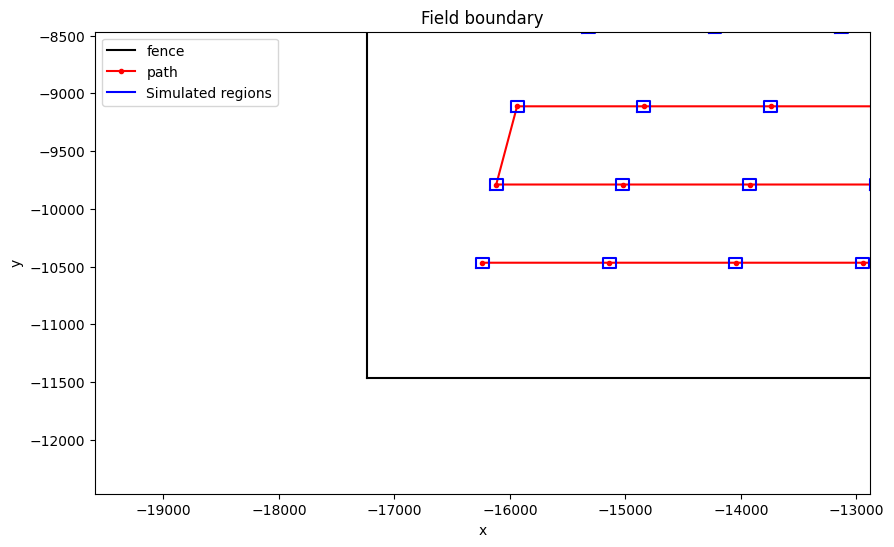

In [12]:
# in mcnp the soil surface is defined by 1 rpp -56 56 -45 45 42 92 $Soil xmin xmax ymin ymax zmin zmax
x_pad = 56
y_pad = 45
z_pad = 92-42

# draw a rectangle around each point in the path
plt.figure(figsize=(10, 6))
plt.plot(fence[:, 0], fence[:, 1], 'k-', label='fence')
plt.plot(path[:, 0], path[:, 1], 'r-', label='path', marker='.')
for point in path[:-1]:
    plt.plot([point[0]-x_pad, point[0]+x_pad, point[0]+x_pad, point[0]-x_pad, point[0]-x_pad],
             [point[1]-y_pad, point[1]-y_pad, point[1]+y_pad, point[1]+y_pad, point[1]-y_pad],
             'b-')
point = path[-1]
plt.plot([point[0]-x_pad, point[0]+x_pad, point[0]+x_pad, point[0]-x_pad, point[0]-x_pad],
         [point[1]-y_pad, point[1]-y_pad, point[1]+y_pad, point[1]+y_pad, point[1]-y_pad],
         'b-', label='Simulated regions')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Field boundary')
plt.axis('equal')
plt.xlim(fence[0][0]-1000, (path[0][0]-(fence[0][0]-1000))+path[0][0])
plt.ylim(fence[0][1]-1000, (path[0][1]-(fence[0][1]-1000))+path[0][1])
plt.show()

# Generating subections

In [13]:
mass_functions

,combo_id,combo,carbon_func,nitrogen_func,carbon_params,nitrogen_params
0,0,const,<function const at 0x76b9ae702830>,<function const at 0x76b9ae702830>,[0.004992609570236395],[0.004992609570236395]
1,1,linear,<function linear at 0x76b9ae7028c0>,<function linear at 0x76b9ae7028c0>,"[0.00019862192575141282, 0.007971863609826437]","[0.00019862192575141282, 0.007971863609826437]"
2,2,plane,<function plane at 0x76b95c6b15a0>,<function plane at 0x76b95c6b15a0>,"[1.5303714398684165e-08, 9.667953700526266e-11...","[1.5303714398684165e-08, 9.667953700526266e-11..."
3,3,quad,<function quad at 0x76b95c6b1630>,<function quad at 0x76b95c6b1630>,"[-4.1382608135894603e-13, 3.689119991081925e-1...","[-4.1382608135894603e-13, 3.689119991081925e-1..."
4,4,quad_plane,<function quad_plane at 0x76b95c6b16c0>,<function quad_plane at 0x76b95c6b16c0>,"[-1.8475158769238626e-13, 3.738134677365824e-1...","[-1.8475158769238626e-13, 3.738134677365824e-1..."


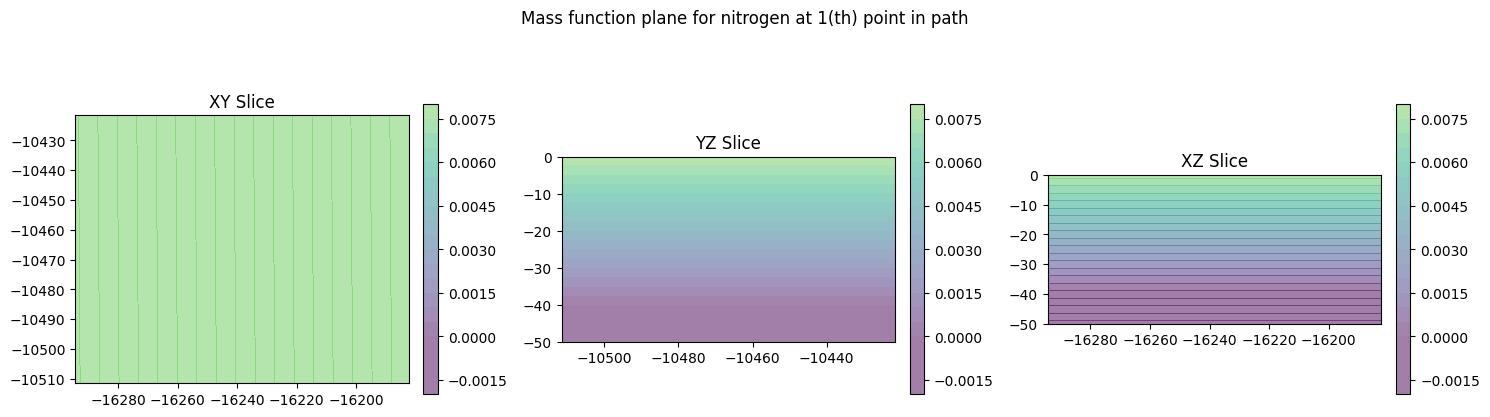

In [14]:
i = 2
j = 0
element = 'nitrogen'


row = mass_functions.iloc[i]
mass_function_params = row[element+'_params']
mass_function_name = row['combo']
_mass_function = row[element+'_func']
mass_function = lambda x_val: _mass_function(x_val, *(mass_function_params))
point = path[j]
x, y = point
soil_z0 = -z_pad
soil_z1 = 0
soil_x0 = x-x_pad
soil_x1 = x+x_pad
soil_y0 = y-y_pad
soil_y1 = y+y_pad


v_min = 0
v_max = .01

fig = plt.figure(figsize=(15, 5))
axs = [fig.add_subplot(131), fig.add_subplot(132), fig.add_subplot(133)]
xy_contf, xy_conc = sm.xy_slice_inspect(axs[0], mass_function, soil_x0, soil_x1, soil_y0, soil_y1, soil_z1, 100, v_min, v_max)
axs[0].set_title('XY Slice')
yz_contf, yz_conc = sm.yz_slice_inspect(axs[1], mass_function, soil_y0, soil_y1, soil_z0, soil_z1, 0, 100, v_min, v_max)
axs[1].set_title('YZ Slice')
xz_contf, xz_conc = sm.xz_slice_inspect(axs[2], mass_function, soil_x0, soil_x1, soil_z0, soil_z1, 0, 100, v_min, v_max)
axs[2].set_title('XZ Slice')

contfs = [xy_contf, yz_contf, xz_contf]
for ax in axs:
    fig.colorbar(contfs[1], ax=ax, fraction=0.04, pad=0.04, boundaries=np.linspace(v_min, v_max, 100))
plt.tight_layout()
plt.suptitle('Mass function '+mass_function_name+' for '+element+' at '+str(j+1)+'(th) point in path')
plt.show()

In [15]:
carbon_mass_function = lambda x_val: np.clip(mass_functions.iloc[i]['carbon_func'](x_val, *mass_functions.iloc[i]['carbon_params']), 0, 1)
nitrogen_mass_function = lambda x_val: np.clip(mass_functions.iloc[i]['nitrogen_func'](x_val, *mass_functions.iloc[i]['nitrogen_params']), 0, 1)
silicone_mass_function = lambda x_val: 1-carbon_mass_function(x_val)-nitrogen_mass_function(x_val)

f = lambda x_val: np.column_stack([carbon_mass_function(x_val), nitrogen_mass_function(x_val), silicone_mass_function(x_val)])

In [16]:
extent = [soil_x0, soil_x1, soil_y0, soil_y1, soil_z0, soil_z1]
res = (5, 5, 5)
sides = sm.cut_bounds(extent, res)
_, midpoints = sm.get_midpoints(sides, res, extent)

In [17]:
f(midpoints).shape

(125, 3)

In [18]:

x_pad = (soil_x1-soil_x0)/res[0]
y_pad = (soil_y1-soil_y0)/res[1]
z_pad = (soil_z1-soil_z0)/res[2]
pad = (x_pad, y_pad, z_pad)
elems = sm.sample_section(f, midpoints, pad, 50)

In [19]:
elem_names = ['carbon', 'nitrogen', 'silicone']
elem_labels = ['6000', '7000', '14000']

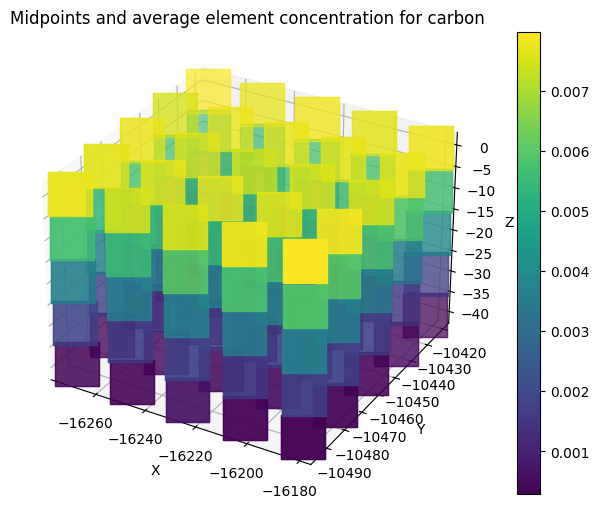

In [20]:
# 3d graph of midpoints and elems
lm = 0
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(midpoints[:, 0], midpoints[:, 1], midpoints[:, 2], c=elems[:, lm], cmap='viridis', s=1000
           , marker='s'
           )
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('Midpoints and average element concentration for '+elem_names[lm])
plt.colorbar(ax.scatter(midpoints[:, 0], midpoints[:, 1], midpoints[:, 2], c=elems[:, lm], cmap='viridis', s=1000
           , marker='s'
           ))
plt.show()

# Generating MCNP input

In [21]:
cells, cell_ids, surfaces, mats = sm.make_mcnp(
    f,
    extent,
    res,
    elem_labels,
    x_fix=x,
    y_fix=y,
)

In [25]:
print(cells)

000 000 -1.05 10 -11 20 -21 30 -31 imp:n,p 1
001 001 -1.05 10 -11 20 -21 31 -32 imp:n,p 1
002 002 -1.05 10 -11 20 -21 32 -33 imp:n,p 1
003 003 -1.05 10 -11 20 -21 33 -34 imp:n,p 1
004 004 -1.05 10 -11 20 -21 34 -35 imp:n,p 1
005 005 -1.05 11 -12 20 -21 30 -31 imp:n,p 1
006 006 -1.05 11 -12 20 -21 31 -32 imp:n,p 1
007 007 -1.05 11 -12 20 -21 32 -33 imp:n,p 1
008 008 -1.05 11 -12 20 -21 33 -34 imp:n,p 1
009 009 -1.05 11 -12 20 -21 34 -35 imp:n,p 1
010 010 -1.05 12 -13 20 -21 30 -31 imp:n,p 1
011 011 -1.05 12 -13 20 -21 31 -32 imp:n,p 1
012 012 -1.05 12 -13 20 -21 32 -33 imp:n,p 1
013 013 -1.05 12 -13 20 -21 33 -34 imp:n,p 1
014 014 -1.05 12 -13 20 -21 34 -35 imp:n,p 1
015 015 -1.05 13 -14 20 -21 30 -31 imp:n,p 1
016 016 -1.05 13 -14 20 -21 31 -32 imp:n,p 1
017 017 -1.05 13 -14 20 -21 32 -33 imp:n,p 1
018 018 -1.05 13 -14 20 -21 33 -34 imp:n,p 1
019 019 -1.05 13 -14 20 -21 34 -35 imp:n,p 1
020 020 -1.05 14 -15 20 -21 30 -31 imp:n,p 1
021 021 -1.05 14 -15 20 -21 31 -32 imp:n,p 1
022 022 -1

In [23]:
print(surfaces)

10 px -56.0
11 px -33.600000000000364
12 px -11.200000000000728
13 px 11.200000000000728
14 px 33.600000000000364
15 px 56.0
20 py -45.0
21 py -27.0
22 py -9.0
23 py 9.0
24 py 27.0
25 py 45.0
30 pz -50.0
31 pz -40.0
32 pz -30.0
33 pz -20.0
34 pz -10.0
35 pz 0.0



In [24]:
print(mats)

m000 6000 -0.0004171321235928395 7000 -0.0004171321235928395 14000 -0.9991657357528143 
m001 6000 -0.0018733039725263646 7000 -0.0018733039725263646 14000 -0.9962533920549475 
m002 6000 -0.00377588648906461 7000 -0.00377588648906461 14000 -0.9924482270218707 
m003 6000 -0.005409287891155563 7000 -0.005409287891155563 14000 -0.9891814242176891 
m004 6000 -0.0077017922454836185 7000 -0.0077017922454836185 14000 -0.9845964155090325 
m005 6000 -0.00044236875941249936 7000 -0.00044236875941249936 14000 -0.999115262481175 
m006 6000 -0.0018080821333554143 7000 -0.0018080821333554143 14000 -0.9963838357332894 
m007 6000 -0.0037531511389013346 7000 -0.0037531511389013346 14000 -0.9924936977221974 
m008 6000 -0.005930580526288185 7000 -0.005930580526288185 14000 -0.9881388389474237 
m009 6000 -0.007817011940691048 7000 -0.007817011940691048 14000 -0.984365976118618 
m010 6000 -0.00033455303105806066 7000 -0.00033455303105806066 14000 -0.9993308939378839 
m011 6000 -0.0014394909952451362 7000 -0